In [70]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [71]:
@jax.jit

def dmglik(y_group,mu,sigma,alpha):
    return(jnp.log(1/alpha)+jax.scipy.stats.norm.logpdf(y_group/alpha,loc = mu,scale = sigma))


In [72]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.5
c = 0.65
s = 10

N_marginal = 139





In [73]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[0], shape=(N, )) + mu
y = y[y>0]

y_obs = y*alpha

y_group2 = jnp.shape(y_obs[y_obs < l ])[0]
y_group3 = y_obs[y_obs > l ]



In [74]:
y_group3 

Array([32.68747 , 41.369675, 36.047455, 49.0251  , 32.21092 , 40.542862,
       34.154514, 37.12065 , 39.28782 , 41.29133 , 36.937923, 32.17774 ,
       33.052917, 32.955643, 42.48758 , 35.40197 , 35.477634, 37.363426,
       32.540283, 33.427814, 40.929207, 39.896763, 33.071266, 38.43323 ,
       35.279457, 35.650482, 40.379627, 46.596413, 35.281937, 32.47872 ,
       32.458984, 40.513783, 32.264565, 47.081482, 33.54442 , 34.780727,
       38.314682, 36.658176, 45.827972, 46.998764, 35.36315 , 34.336327,
       33.40924 , 37.381207, 38.00228 , 34.552315, 41.873806, 37.50255 ,
       34.81786 , 35.832096, 32.84271 , 42.08113 , 46.022118, 33.99768 ,
       41.608734, 36.96572 , 32.4138  , 36.25449 , 32.706394, 32.18146 ],      dtype=float32)

In [75]:

@jax.jit
def negdmglik_jax(alpha):
    lik2 = y_group2*jnp.log(
        jax.scipy.stats.norm.cdf(l/alpha, loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(1e-6/alpha, loc=mu, scale=sigma)
        )
    lik3 = jnp.sum(jax.vmap(lambda y_obs: dmglik(y_obs,mu,sigma,alpha))(y_group3))

    return(-lik2-lik3)

negdmglik_jax(alpha)

Array(309.91583, dtype=float32)

In [76]:


solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(alpha)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
alpha

(Array(0.4988281, dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(309.90942, dtype=float32), success=True, status=0, iter_num=9, hess_inv=None))

0.5

In [77]:
 negdmglik_jax(.1)
 negdmglik_jax(.2)
 negdmglik_jax(.05)


Array(8982.934, dtype=float32)

Array(1760.2118, dtype=float32)

Array(40966.543, dtype=float32)

In [78]:
jnp.sum(jax.vmap(lambda y_obs: dmglik(y_obs,mu,sigma,alpha))(y_group3))

Array(-254.66708, dtype=float32)

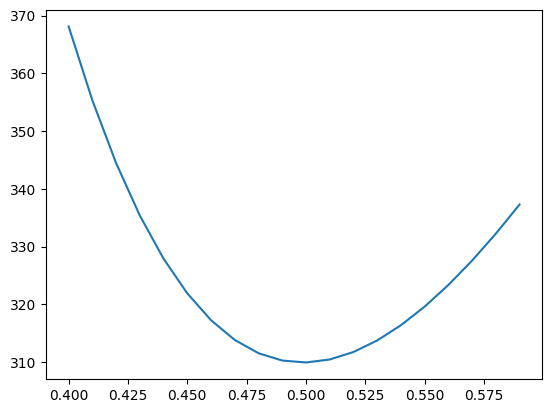

In [79]:
alpha_seq = jnp.arange(alpha -0.1, alpha+0.1,0.01)
lik_seq = jax.vmap(negdmglik_jax)(alpha_seq )
plt.plot(alpha_seq,lik_seq)